In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier,VotingClassifier
from sklearn.model_selection import GridSearchCV,cross_validate,RandomizedSearchCV,validation_curve
from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
df = pd.read_csv("diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [2]:
def outliers(df,variable):
    q1= df[variable].quantile(0.10)
    q3 = df[variable].quantile(0.90)
    iqr = q3 - q1
    lower_lim = q1 - 1.5*iqr
    upper_lim = q3 + 1.5*iqr
    return lower_lim,upper_lim

def check_outliers(df,variable):
    lower_lim,upper_lim = outliers(df,variable)
    if df.loc[(df[variable]<lower_lim) | (df[variable]>upper_lim)].any(axis=None):
        return True
    else:
        return False
    
def replace_outliers(df,variable):
    lower_lim, upper_lim = outliers(df,variable)
    df[variable].clip(lower=lower_lim, upper=upper_lim,inplace=True)
    
df["Glucose"] =df["Glucose"].replace(0,np.nan)
df["BloodPressure"] = df["BloodPressure"].replace(0,np.nan)
df["SkinThickness"] = df["SkinThickness"].replace(0,np.nan)
df["Insulin"] = df["Insulin"].replace(0,np.nan)
df["BMI"] = df["BMI"].replace(0,np.nan)
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
imp= IterativeImputer(
    estimator=XGBRegressor(n_estimators=300,max_depth=7),
    max_iter=30,
    random_state=0
).set_output(transform="pandas")

df=imp.fit_transform(df)

c:\Users\oskar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\impute\_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [3]:
X = df.drop("Outcome",axis=1)
y = df["Outcome"]
rf = RandomForestClassifier()
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [4]:
cv_results = cross_validate(rf,X,y,cv=10,scoring=["accuracy","precision","f1","roc_auc"])
cv_results["test_accuracy"].mean()

0.7759911141490089

In [5]:
cv_results["test_precision"].mean()

0.7116446064591846

In [6]:
cv_results["test_roc_auc"].mean()

0.8383575498575497

In [7]:
cv_results["test_f1"].mean()

0.6506170373535619

In [8]:
rf_params = {'max_depth': [6,8],
             "max_features":['sqrt',4,5],
            'min_samples_split': [9,10],
             'n_estimators': [250,300,350]}
gs = GridSearchCV(rf,rf_params,cv=10,n_jobs=-1).fit(X,y)

In [9]:
gs.best_params_

{'max_depth': 6,
 'max_features': 5,
 'min_samples_split': 9,
 'n_estimators': 250}

In [10]:
rf_final = rf.set_params(**gs.best_params_,random_state=10).fit(X,y)

In [11]:
cv_results = cross_validate(rf_final,X,y,cv=10,scoring=["accuracy","precision","f1","roc_auc"])
cv_results["test_accuracy"].mean()

0.7773069036226932

In [12]:
cv_results["test_precision"].mean()

0.7007768527403578

In [13]:
cv_results["test_roc_auc"].mean()

0.8433418803418803

In [14]:
rf_final.fit(X,y)

RandomForestClassifier(max_depth=6, max_features=5, min_samples_split=9,
                       n_estimators=250, random_state=10)

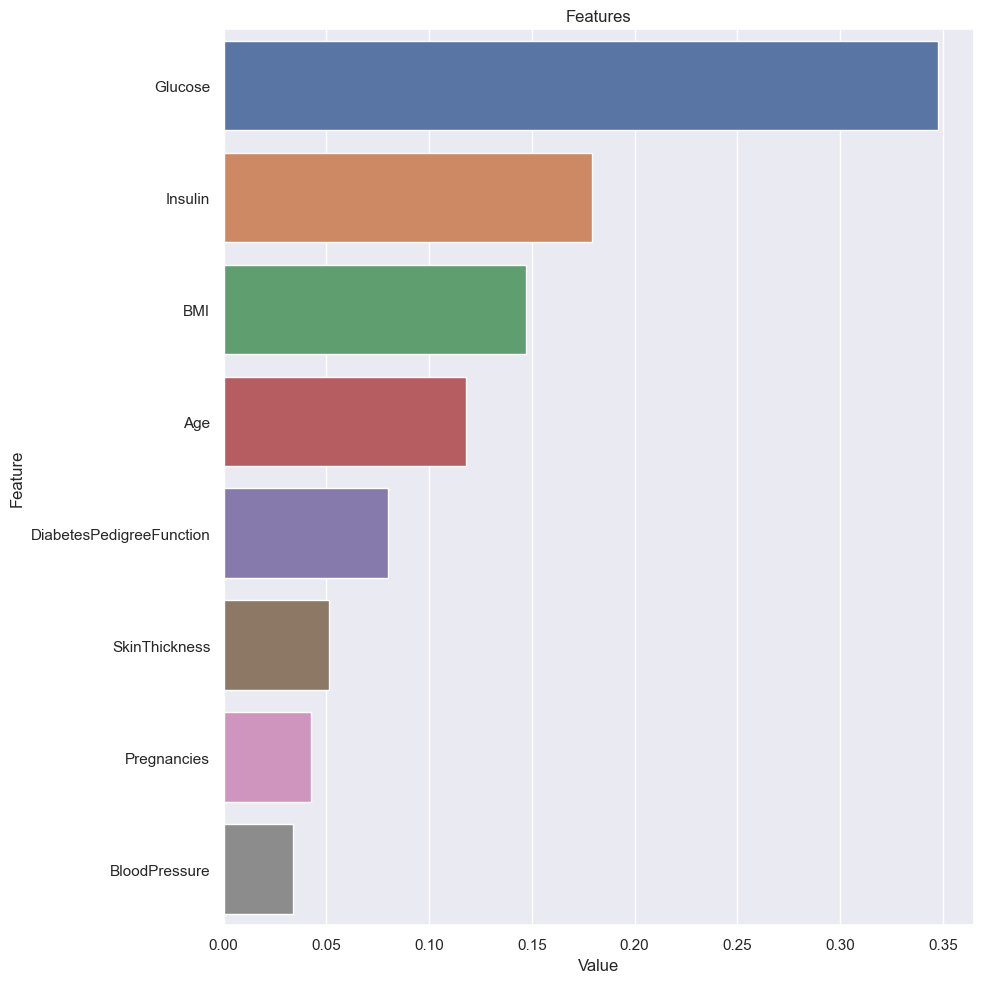

In [15]:
def plot_imp(model, features, num=None, save=False):
    if num is None:
        num = len(features)
    
    feature_imp = pd.DataFrame({"Value":model.feature_importances_, "Feature":list(features.columns)})
    feature_imp = feature_imp.sort_values(by="Value", ascending=False).iloc[:num]
    
    plt.figure(figsize=(10,10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp)
    
    plt.title("Features")
    plt.tight_layout()
    plt.show()
    
    if save:
        plt.savefig(f"{model}.importances.png")
        
plot_imp(rf_final,X)

In [16]:
from sklearn.preprocessing import RobustScaler
rb = RobustScaler()
x2 = rb.fit_transform(X)

In [17]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
log_clf = LogisticRegression(solver='lbfgs', multi_class='auto')
xgb_clf = XGBClassifier(max_depth=6)
voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rf_final), ('xgb', xgb_clf)],
    voting='soft',
    weights=[1,2, 0]  
)
voting_clf

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf',
                              RandomForestClassifier(max_depth=6,
                                                     max_features=5,
                                                     min_samples_split=9,
                                                     n_estimators=250,
                                                     random_state=10)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=Fals...
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=6,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=None, ...))],
                 voting='soft', weights=[1, 2, 0])

In [21]:
cv_results = cross_validate(voting_clf,x2,y,cv=10,scoring=["accuracy","precision","f1","roc_auc"])
cv_results["test_accuracy"].mean()

0.7734107997265892

In [19]:
cv_results["test_precision"].mean()

0.7112053405531666

In [20]:
cv_results["test_roc_auc"].mean()

0.8491680911680911

In [22]:
log_clf = LogisticRegression(solver='lbfgs', multi_class='auto')
xgb_clf = XGBClassifier(max_depth=6)
voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rf_final), ('xgb', xgb_clf)],
    voting='hard'  
)
voting_clf

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf',
                              RandomForestClassifier(max_depth=6,
                                                     max_features=5,
                                                     min_samples_split=9,
                                                     n_estimators=250,
                                                     random_state=10)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=Fals...
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=6,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=None, ...))])

In [23]:
voting_clf.fit(x2,y)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf',
                              RandomForestClassifier(max_depth=6,
                                                     max_features=5,
                                                     min_samples_split=9,
                                                     n_estimators=250,
                                                     random_state=10)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=Fals...
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=6,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=None, ...))])

In [24]:
voting_clf.predict(x2)

array([1., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 0., 1.,
       1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 1., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 1., 0., 0.,
       0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       1., 1., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 1.,
       1., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 0.

In [25]:
cv_results = cross_validate(voting_clf,x2,y,cv=10,scoring=["accuracy","precision","f1"])
cv_results["test_accuracy"].mean()

0.7773410799726589

In [26]:
cv_results["test_precision"].mean()

0.7075417105565847

In [27]:
cv_results["test_f1"].mean()

0.6601977117466804

In [32]:
cv_results = cross_validate(xgb_clf,X,y,cv=10,scoring=["accuracy","precision","f1","roc_auc"])
cv_results["test_accuracy"].mean()

0.7487525632262474

In [33]:
cv_results["test_precision"].mean()

0.6528761423761422

In [34]:
cv_results["test_f1"].mean()

0.6288279608593044

In [35]:
xgb_clf.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': None,
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 6,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [36]:
xgb_params = {"learning_rate":[0.1,0.01,0.07],
              "max_depth":[5,6],
              "n_estimators":[100,300,500],
              "colsample_bytree":[0.7,1]}

xg_gs = GridSearchCV(xgb_clf,xgb_params,cv=10,n_jobs=-1,).fit(X,y)

In [37]:
xg_gs.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.01,
 'max_depth': 6,
 'n_estimators': 300}

In [38]:
xgb_clf = xgb_clf.set_params(**xg_gs.best_params_)
cv_results = cross_validate(xgb_clf,X,y,cv=10,scoring=["accuracy","precision","f1","roc_auc"])
cv_results["test_accuracy"].mean()

0.7785885167464114

In [39]:
cv_results["test_precision"].mean()

0.7091748149193802

In [40]:
cv_results["test_f1"].mean()

0.6637700316901285

In [52]:
lgb_clf = LGBMClassifier(verbose = -1)
cv_results = cross_validate(lgb_clf,X,y,cv=10,scoring=["accuracy","precision","f1","roc_auc"])
cv_results["test_accuracy"].mean()

0.7448222829801777

In [53]:
cv_results["test_precision"].mean()

0.6469119286510591

In [54]:
cv_results["test_f1"].mean()

0.6213264614455655

In [55]:
param_grid = {
    'num_leaves': [20, 40],
    'reg_alpha': [ 0.1, 0.5, 1.0],  # L1 regülarizasyonu (lambda_l1)
    'reg_lambda': [0.1, 0.5, 1.0], # L2 regülarizasyonu (lambda_l2)
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100,300,400]
}


xg_gs = GridSearchCV(lgb_clf,param_grid,cv=10,n_jobs=-1,).fit(X,y)

In [56]:
gs.best_params_

{'max_depth': 6,
 'max_features': 5,
 'min_samples_split': 9,
 'n_estimators': 250}

In [60]:
lgb_clf = lgb_clf.set_params(**gs.best_params_)
cv_results = cross_validate(lgb_clf,X,y,cv=10,scoring=["accuracy","precision","f1","roc_auc"])
cv_results["test_accuracy"].mean()

0.7383116883116883

In [58]:
cv_results["test_precision"].mean()

0.634369060674279

In [59]:
cv_results["test_f1"].mean()

0.612699758623297

In [63]:
from sklearn.ensemble import BaggingClassifier
bagged_lgb = BaggingClassifier(
    estimator=lgb_clf,
    n_estimators=50,  # 50 farklı bootstrap örnek üzerinde 50 XGBoost modeli oluşturulacak
    bootstrap=True,
    n_jobs=-1,
    random_state=42
)

In [64]:
cv_results = cross_validate(bagged_lgb,X,y,cv=10,scoring=["accuracy","precision","f1","roc_auc"])
cv_results["test_accuracy"].mean()

0.7643028024606973

In [65]:
cv_results["test_precision"].mean()

0.6867774401329801

In [66]:
cv_results["test_f1"].mean()

0.6421628229732204

In [68]:
ctb_clf = CatBoostClassifier(verbose=False)
cv_results = cross_validate(ctb_clf,X,y,cv=10,scoring=["accuracy","precision","f1","roc_auc"])
cv_results["test_accuracy"].mean()

0.7643198906356801

In [69]:
cv_results["test_precision"].mean()

0.6792571920832791

In [70]:
cv_results["test_f1"].mean()

0.6471056933027517

In [86]:
params = {"learning_rate":[0.1,0.01,0.07],
              "depth":[5,6],
              "iterations":[100,200,300]}

ctb_gs = GridSearchCV(ctb_clf,params,cv=10,n_jobs=-1,).fit(X,y)

In [87]:
ctb_gs.best_params_

{'depth': 5, 'iterations': 100, 'learning_rate': 0.1}

In [88]:
ctb_clf = ctb_clf.set_params(**ctb_gs.best_params_)
cv_results = cross_validate(ctb_clf,X,y,cv=10,scoring=["accuracy","precision","f1","roc_auc"])
cv_results["test_accuracy"].mean()

0.7682330827067668

In [89]:
cv_results["test_precision"].mean()

0.7034519965210502

In [90]:
cv_results["test_f1"].mean()

0.6415539017438714

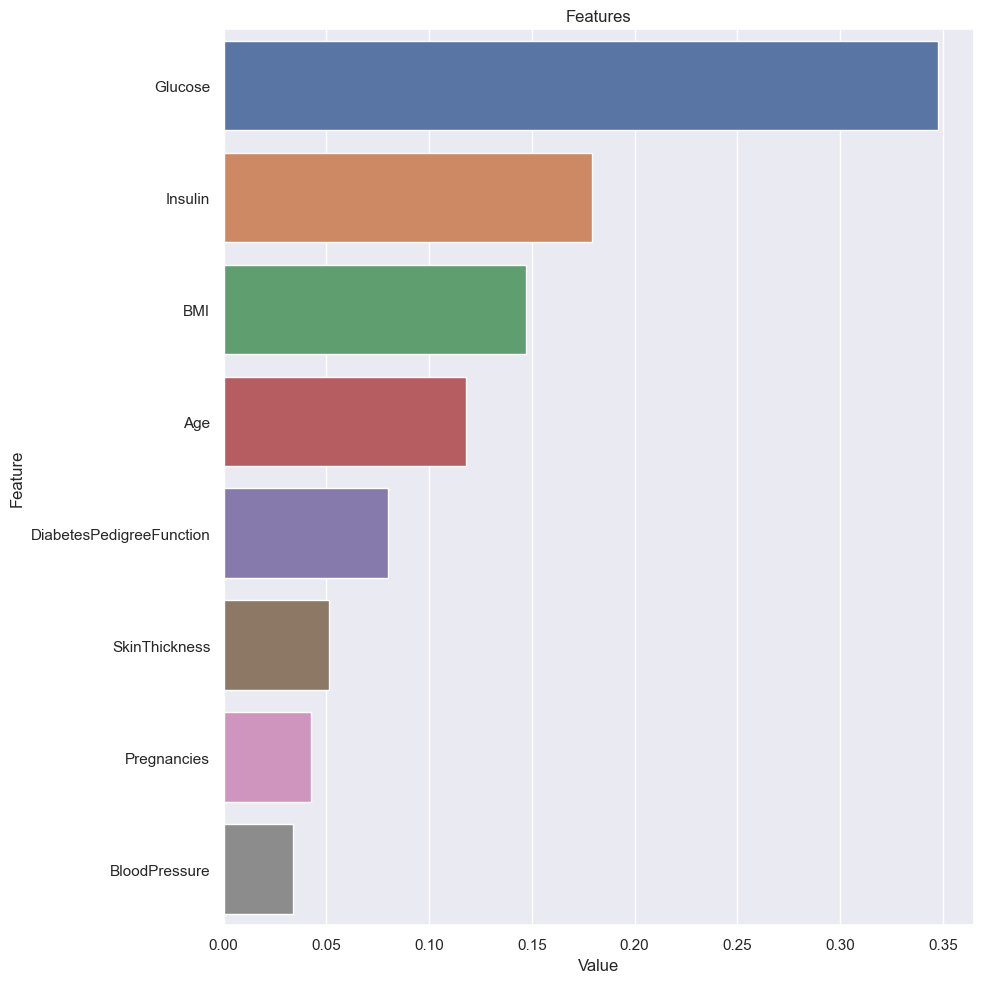

In [91]:
def plot_imp(model, features, num=None, save=False):
    if num is None:
        num = len(features)
    
    feature_imp = pd.DataFrame({"Value":model.feature_importances_, "Feature":list(features.columns)})
    feature_imp = feature_imp.sort_values(by="Value", ascending=False).iloc[:num]
    
    plt.figure(figsize=(10,10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp)
    
    plt.title("Features")
    plt.tight_layout()
    plt.show()
    
    if save:
        plt.savefig(f"{model}.importances.png")
        
plot_imp(rf_final,X)

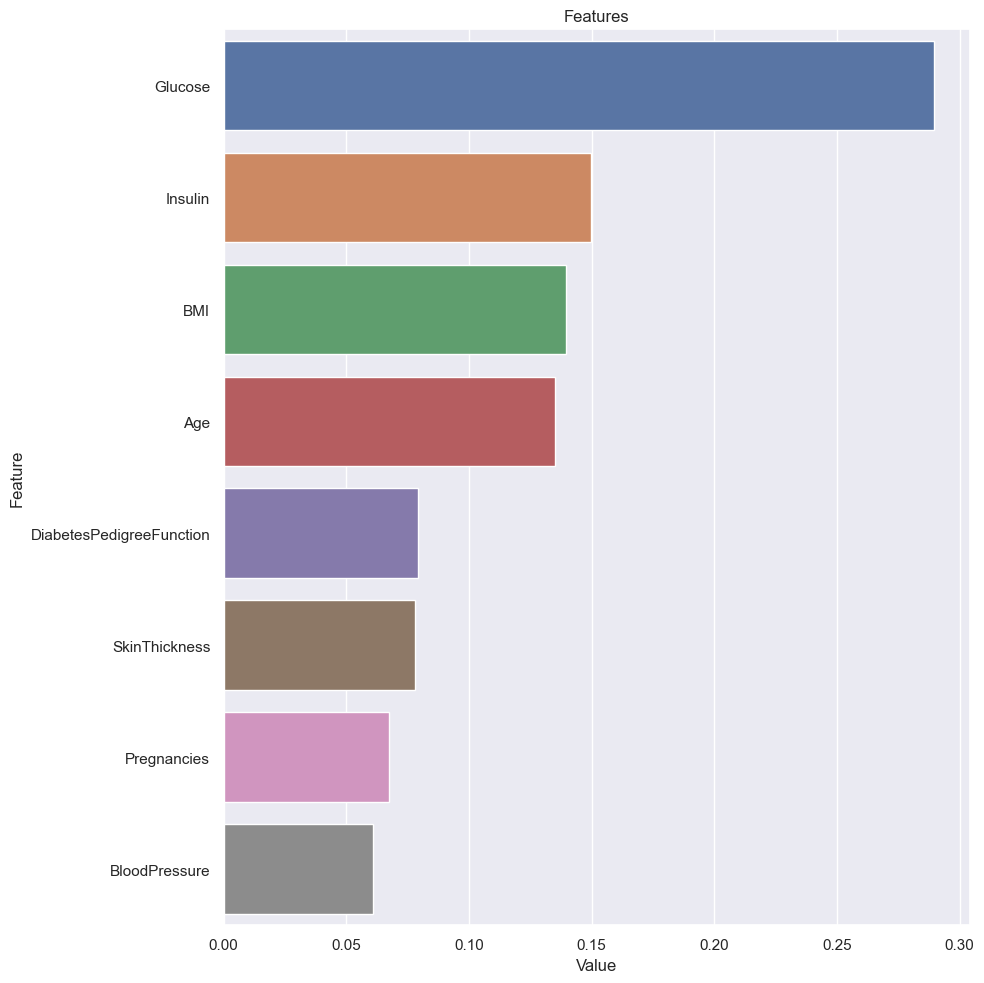

In [92]:
xgb_clf.fit(X,y)
plot_imp(xgb_clf,X)

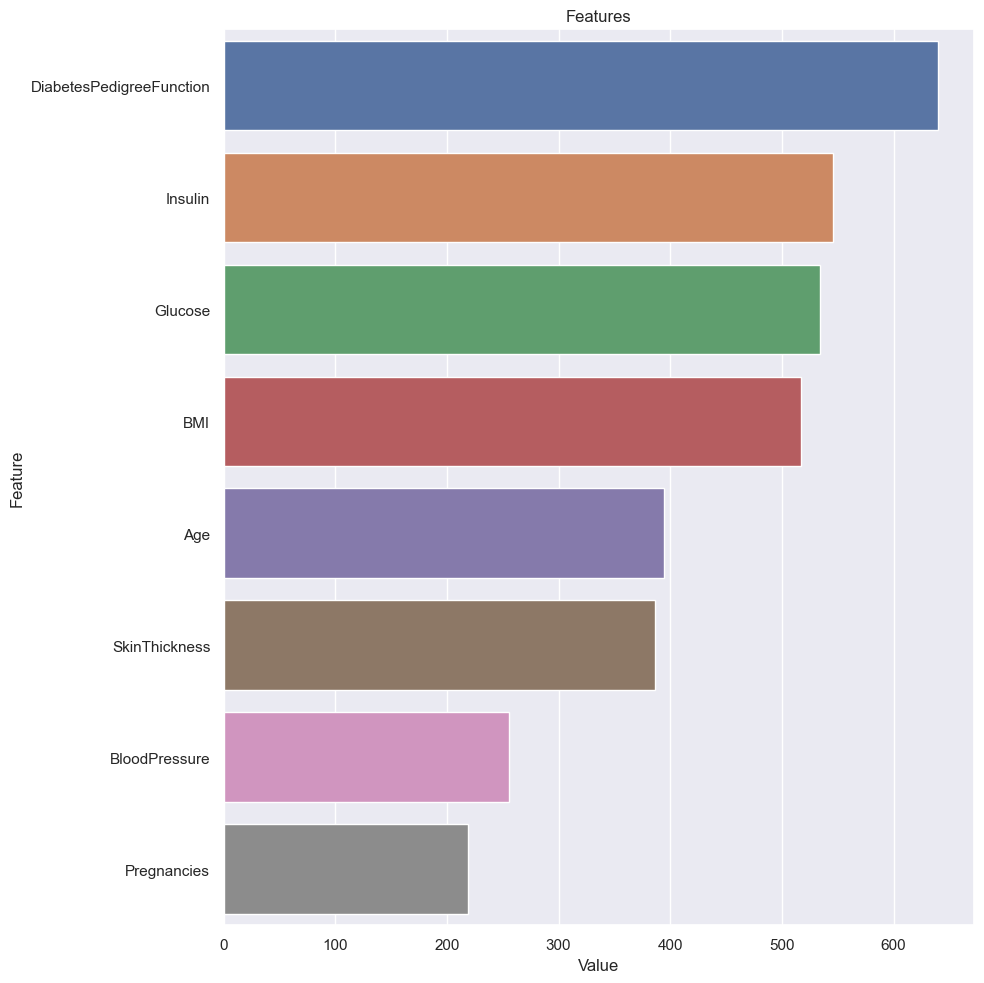

In [95]:
lgb_clf.fit(X,y)
plot_imp(lgb_clf,X)

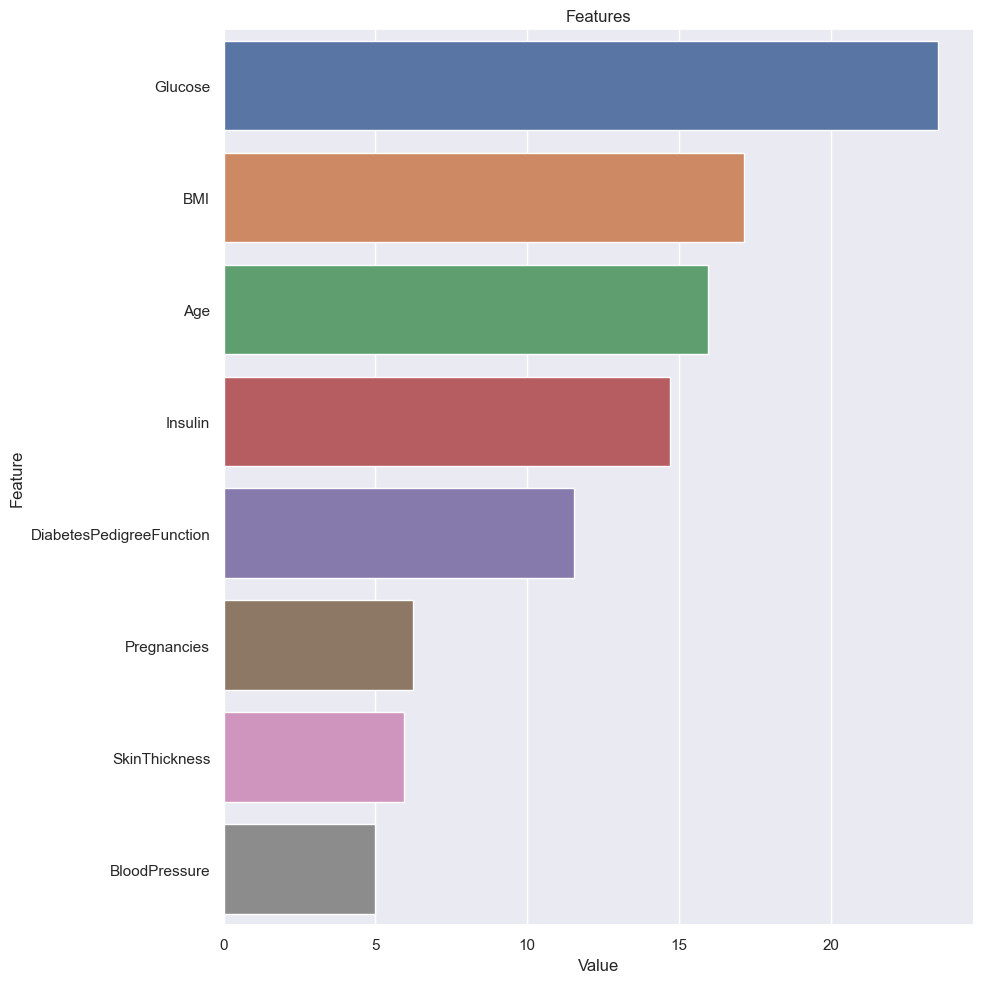

In [94]:
ctb_clf.fit(X,y)
plot_imp(ctb_clf,X)

In [98]:
rf_model = RandomForestClassifier(random_state=10)
rf_random_params = {"max_depth":np.random.randint(5,30,10),
                    "max_features":[3,4,5,"sqrt"],
                    "min_samples_split":np.random.randint(2,50,20),
                    "n_estimators":[int(x) for x in np.linspace(start=200,stop=1000,num=10)]}

rf_random = RandomizedSearchCV(estimator=rf_model,param_distributions=rf_random_params,
                               n_iter=100,# denenecek parametre sayısı
                               cv=10,
                               random_state=10,
                               n_jobs=-1).fit(X,y)

In [99]:
rf_random.best_params_

{'n_estimators': 377,
 'min_samples_split': 11,
 'max_features': 4,
 'max_depth': 10}

In [100]:
rf_random = rf_model.set_params(**rf_random.best_params_)
cv_results = cross_validate(rf_random,X,y,cv=10,scoring=["accuracy","precision","f1","roc_auc"])
cv_results["test_accuracy"].mean()

0.7760594668489406

In [101]:
cv_results["test_precision"].mean()

0.7001677742547308

In [102]:
cv_results["test_f1"].mean()

0.6608399380682682

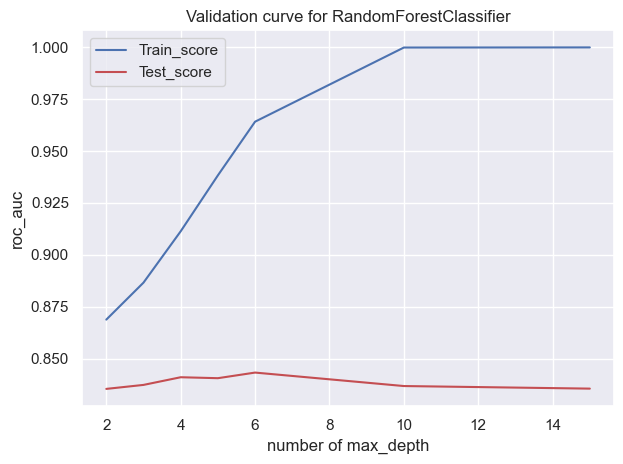

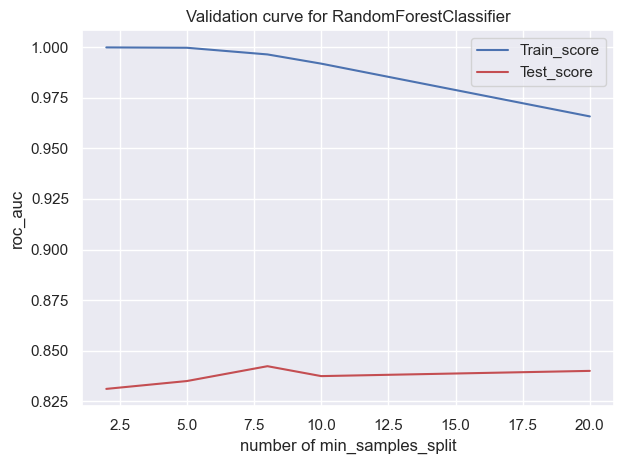

In [103]:
def val_curve(model,X,y,param_name,param_range,scoring="roc_auc",cv=10):
    train_score, test_score= validation_curve(model,X,y,param_name=param_name,
                                              param_range=param_range,
                                              scoring=scoring,cv=cv)
    
    mean_train_score = np.mean(train_score,axis=1)
    mean_test_score = np.mean(test_score,axis=1)
    plt.plot(param_range,mean_train_score,label="Train_score",color="b")
    plt.plot(param_range,mean_test_score,label="Test_score",color="r")
    plt.title(f"Validation curve for {type(model).__name__}")
    plt.xlabel(f"number of {param_name}")
    plt.ylabel(f"{scoring}")
    plt.tight_layout()
    plt.legend(loc="best")
    plt.show(block=True)
    
    
rf_val_params = [["max_depth",[2,3,4,5,6,10,15]],
                 ["min_samples_split",[2,5,8,10,20]]]

rf2 = RandomForestClassifier(random_state=10)
for i in range(len(rf_val_params)):
    val_curve(rf2,X,y,rf_val_params[i][0],rf_val_params[i][1])